# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import spacy
from collections import Counter


import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds
import pickle

import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Read Dataframe

In [2]:
# Read the created dataset
df = pd.read_csv('../data/Result/dataset.csv')

# Print the first rows of the dataset
df.head()

,Text,Class
0,I have heard nothing from the Ambassador about...,Political speech
1,I think it is in the public interest to procee...,Political speech
2,The A-11 aircraft now at Edwards Air force Bas...,Political speech
3,It is one of the most comprehensive bills in t...,Political speech
4,"So long as there remains a man without a job, ...",Political speech


# Data Preprocessing

In [ ]:
# https://spacy.io/usage
!python -m spacy download en_core_web_sm

In [3]:
# Load the spacy model
nlp = spacy.load("en_core_web_sm")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.4.1) was trained with spaCy v3.4 and may not be 100% compatible with the current version (3.6.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [4]:
# Count the number of texts for the different classes
class_counts = Counter(df['Class'])
class_counts

Counter({'Political speech': 797,
         'News': 1001,
         'Jurisdiction': 780,
         'Literature': 952,
         'Blog': 998})

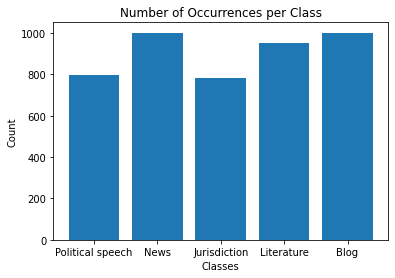

In [5]:
# Show current occurences of the different classes in the dataframe
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Number of Occurrences per Class')
plt.show()

## Balancing the dataset

In [6]:
# Get minimum number of occurences
min_count = min(class_counts.values())

df_balanced = pd.DataFrame()

# Iterate over all classes
for category in class_counts.keys():
    # Get a random sample of the category, so it gets downsampled based on the minimum count of occurences
    category_subset = df[df['Class'] == category].sample(n=min_count, random_state=42, ignore_index=True)
    df_balanced =pd.concat([category_subset, df_balanced], ignore_index=True)

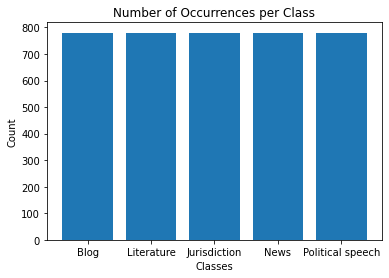

In [7]:
class_counts_balanced = Counter(df_balanced['Class'])

# Show occurences of the different classes in the balanced dataframe
plt.bar(class_counts_balanced.keys(), class_counts_balanced.values())
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Number of Occurrences per Class')
plt.show()

In [8]:
# Dictionary for converting the classes to numeric representation for the usage in the model
classes_mapping = {
    'Literature': 0,
    'News': 1,
    'Blog': 2,
    'Political speech': 3,
    'Jurisdiction': 4
}

df_balanced = df_balanced.replace({"Class": classes_mapping})

In [9]:
df_balanced.head()

,Text,Class
0,"Then she said, 'Can you come in today at 4 p.m...",2
1,"The city of San Francisco, gay capital of Amer...",2
2,After recess was Social Studies for 2 periods....,2
3,The thought of having three to precept and bri...,2
4,"Nobody ever took me aside and said 'hey, you a...",2


## Further Preprocessing
Quelle: https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34

In [39]:
raw_text = df_balanced['Text']
# Change to lowercase
modified_text = [entry.lower() for entry in raw_text]
# Tokenization
modified_text = [word_tokenize(entry) for entry in modified_text]

preprocessed_text = []

# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
for index,entry in enumerate(modified_text):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    preprocessed_text.append(str(Final_words))


In [40]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(preprocessed_text, df_balanced['Class'],test_size=0.2, random_state=42)

In [41]:
# Transformation of the text data into vectors, so that the models can process the data
Tfidf_vect = TfidfVectorizer()
Tfidf_vect.fit(preprocessed_text)
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [52]:
# Save the TF-IDF Vectorizer for further usage (https://docs.python.org/3/library/pickle.html)

filename = './vectorizers/tfidf-vectorizer.sav'
pickle.dump(Tfidf_vect, open(filename, 'wb'))

# Model creation and evaluation

## Naive Bayes Classification
Source: https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34

In [58]:
model_naive = naive_bayes.MultinomialNB()
model_naive.fit(Train_X_Tfidf,Train_Y)

# predict the labels on test dataset
predictions_NB = model_naive.predict(Test_X_Tfidf)

naive_score = accuracy_score(predictions_NB, Test_Y)*100

# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ", naive_score, "%")

Naive Bayes Accuracy Score ->  90.0 %


## SVM Classification
Source: https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34, https://www.codingninjas.com/studio/library/svm-hyperparameter-tuning-using-gridsearchcv

In [55]:
# Set the parameter grid for the hyperparamtertuning

param_grid = {'C': [0.1,1, 10, 100], 
              'gamma': [1,0.1,0.01,0.001],
              'kernel': ['poly','rbf', 'sigmoid','linear']}
                  
model_svm = GridSearchCV(svm.SVC(probability=True), param_grid, refit = True, cv = 3, verbose = 3)

# Fit the model on the training data
model_svm.fit(Train_X_Tfidf,Train_Y)

# predict the labels on test dataset
predictions_SVM = model_svm.predict(Test_X_Tfidf)

svm_score = accuracy_score(predictions_SVM, Test_Y)*100

# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ", svm_score, "%")

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV 1/3] END .......C=0.1, gamma=1, kernel=poly;, score=0.205 total time=  36.9s
[CV 2/3] END .......C=0.1, gamma=1, kernel=poly;, score=0.278 total time=  38.3s
[CV 3/3] END .......C=0.1, gamma=1, kernel=poly;, score=0.207 total time=  41.3s
[CV 1/3] END ........C=0.1, gamma=1, kernel=rbf;, score=0.460 total time=  41.4s
[CV 2/3] END ........C=0.1, gamma=1, kernel=rbf;, score=0.587 total time=  39.7s
[CV 3/3] END ........C=0.1, gamma=1, kernel=rbf;, score=0.516 total time=  40.1s
[CV 1/3] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.902 total time=  32.3s
[CV 2/3] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.902 total time=  31.4s
[CV 3/3] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.894 total time=  31.1s
[CV 1/3] END .....C=0.1, gamma=1, kernel=linear;, score=0.902 total time=  32.2s
[CV 2/3] END .....C=0.1, gamma=1, kernel=linear;, score=0.902 total time=  31.9s
[CV 3/3] END .....C=0.1, gamma=1, kernel=linear

## kNN Classification
Source: https://medium.com/@salemortega/k-neighbors-classifier-with-gridsearchcv-basics-3c445ddeb657

In [44]:
# Set the parameter grid for the hyperparamtertuning
param_grid = {'n_neighbors': [3, 5, 11, 19], 
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan']}
                  
model_knn = GridSearchCV(KNeighborsClassifier(), param_grid, refit = True, verbose = 3, cv = 5)

# Fit the model on the training data
model_knn.fit(Train_X_Tfidf,Train_Y)

# predict the labels on test dataset
predictions_kNN = model_knn.predict(Test_X_Tfidf)

kNN_score = accuracy_score(predictions_kNN, Test_Y)*100

# Use accuracy_score function to get the accuracy
print("kNN Accuracy Score -> ", kNN_score, "%")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.824 total time=   0.1s
[CV 2/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.856 total time=   0.1s
[CV 3/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.853 total time=   0.1s
[CV 4/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.833 total time=   0.1s
[CV 5/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.832 total time=   0.1s
[CV 1/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.809 total time=   0.1s
[CV 2/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.851 total time=   0.1s
[CV 3/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.838 total time=   0.1s
[CV 4/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.819 total time=   0.1s
[CV 5/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.803 tot

## BERT Classification
Source: https://towardsdatascience.com/fine-tuning-bert-for-text-classification-54e7df642894

### Data preprocessing

In [33]:
# Get texts and classes of dataframe
texts = df_balanced.Text.values
classes = df_balanced.Class.values

bert_data = pd.DataFrame({'texts':texts, 'classes': classes})

# Indices of the train and test splits stratified by labels
train_val_data_bert, test_data_bert = train_test_split(
    bert_data,
    test_size = 0.1,
    random_state=42)

In [34]:
# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True
    )

model_bert = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    # set number of classes to classes in df['Class']
    num_labels = len(df['Class'].unique()),
    output_attentions = False,
    output_hidden_states = False,
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [35]:
token_id = []
attention_masks = []

def preprocessing(text, tokenizer):

  return tokenizer.encode_plus(
                        text,
                        add_special_tokens = True,
                        max_length = 128,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )


for sample in train_val_data_bert['texts']:
  encoding_dict = preprocessing(sample, tokenizer)
  token_id.append(encoding_dict['input_ids']) 
  attention_masks.append(encoding_dict['attention_mask'])


token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
classes = torch.tensor(list(train_val_data_bert['classes']))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [36]:
val_ratio = 0.2

batch_size = 16

# Indices of the train and test splits stratified by labels
train_idx, val_idx = train_test_split(
    np.arange(len(classes)),
    test_size = val_ratio,
    shuffle = True,
    stratify = classes)

# Train and test sets
train_set = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          classes[train_idx])

val_set = TensorDataset(token_id[val_idx], 
                        attention_masks[val_idx], 
                        classes[val_idx])

# Prepare DataLoader
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

val_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )

### Model training and evaluation

In [37]:
optimizer = torch.optim.AdamW(model_bert.parameters(), 
                              lr = 2e-5,
                              )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 2

for epoch in range(num_epochs):
    
    # ========== Training ==========
    
    # Set model to training mode
    model_bert.train()
    
    # Tracking variables
    tr_loss = 0
    tr_accuracy = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model_bert(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    avg_loss = tr_loss / nb_tr_steps

    # ========== Evaluation ==========

    # Set model to evaluation mode
    model_bert.eval()

    total_correct = 0
    total_samples = 0

    for batch in val_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            # Forward pass
            eval_output = model_bert(b_input_ids, 
                            token_type_ids = None, 
                            attention_mask = b_input_mask)
            logits = eval_output.logits
            label_ids = b_labels.to('cpu').numpy()
            # Calculate validation metrics

            _, predicted_labels = torch.max(logits, 1)

            total_correct += (predicted_labels == b_labels).sum().item()
            total_samples += b_labels.size(0)

    accuracy = total_correct / total_samples

    print(f"Epoch {epoch+1}:")
    print(f"  Loss: {avg_loss:.4f}")
    print(f"  Val Accuracy: {accuracy:.4f}")

Epoch 1:
  Loss: 0.4888
  Val Accuracy: 0.9459
Epoch 2:
  Loss: 0.1105
  Val Accuracy: 0.9587


In [38]:
predictions_bert = []

# Preprocessing of the text to be used by the Bert-Model
for sample in test_data_bert['texts']:
    test_ids = []
    test_attention_mask = []
    encoding = preprocessing(sample, tokenizer)
    test_ids.append(encoding['input_ids'])
    test_attention_mask.append(encoding['attention_mask'])
    test_ids = torch.cat(test_ids, dim = 0)
    test_attention_mask = torch.cat(test_attention_mask, dim = 0)

    # Get the prediction for the sample from the model
    with torch.no_grad():
        output = model_bert(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))
    predictions_bert.append(np.argmax(output.logits.cpu().numpy()).flatten().item())
bert_score = accuracy_score(predictions_bert, list(test_data_bert['classes']))*100

# Use accuracy_score function to get the accuracy
print("BERT Accuracy Score -> ", bert_score, "%")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


BERT Accuracy Score ->  96.66666666666667 %


## Model comparison

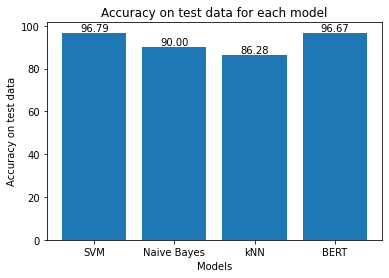

In [50]:
# Show test accuracy for each trained model
scores = [svm_score, naive_score, kNN_score, bert_score]
plt.bar(['SVM', 'Naive Bayes', 'kNN', 'BERT'], scores)
plt.xlabel('Models')
plt.ylabel('Accuracy on test data')
plt.title('Accuracy on test data for each model')
# Add text annotations for the accuracy scores of the models
for i, score in enumerate(scores):
    plt.text(i, score, '{:.2f}'.format(score), ha='center', va='bottom')
plt.show()

## Export the Model

In [54]:
# Save the model to disk (https://docs.python.org/3/library/pickle.html)
filename = './models/finalized_model.sav'
pickle.dump(model_svm, open(filename, 'wb'))